In [1]:
!git clone https://github.com/leap-stc/ClimSim.git

# Step 2: Navigate to the cloned repository directory
%cd ClimSim

# Step 3: Install the climsim_utils package
!pip install .

Cloning into 'ClimSim'...
remote: Enumerating objects: 4506, done.
remote: Counting objects: 100% (811/811), done.
remote: Compressing objects: 100% (357/357), done.
remote: Total 4506 (delta 461), reused 718 (delta 441), pack-reused 3695
Receiving objects: 100% (4506/4506), 140.16 MiB | 17.72 MiB/s, done.
Resolving deltas: 100% (1554/1554), done.
Updating files: 100% (2068/2068), done.
/content/ClimSim
Processing /content/ClimSim
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.5 MB/s eta 0:00:00
  Created wheel for climsim-utils: filename=climsim_utils-0.0.1-py3-none-any.whl size=14489 sha256=14eb93702f487a720871039c8318bce6df45c8191c1e739fd253e276b2a57ab9
  Stored in directory: /tmp/pip-ephem-wheel-cache-58otk3vm/wheels/a2/10/6e/125ae0c7cf1c521a7afaa0ba206e930d032a286728ae1a9103
Successfully built climsim-utils


In [2]:
!pip install netCDF4

In [3]:
from climsim_utils.data_utils import *

In [4]:
grid_path = 'grid_info/ClimSim_low-res_grid-info.nc'
norm_path = 'preprocessing/normalizations/'

grid_info = xr.open_dataset(grid_path)
input_mean = xr.open_dataset(norm_path + 'inputs/input_mean.nc')
input_max = xr.open_dataset(norm_path + 'inputs/input_max.nc')
input_min = xr.open_dataset(norm_path + 'inputs/input_min.nc')
output_scale = xr.open_dataset(norm_path + 'outputs/output_scale.nc')

data = data_utils(grid_info = grid_info,
                  input_mean = input_mean,
                  input_max = input_max,
                  input_min = input_min,
                  output_scale = output_scale)

# set variables to V1 subset
data.set_to_v1_vars()

In [5]:
os.getcwd()

'/content/ClimSim'

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
# Change this path to your own

train_input_path = '/content/drive/MyDrive/Colab Notebooks/GU4243_Prj3/Raw_Data/train_input.npy'
train_target_path = '/content/drive/MyDrive/Colab Notebooks/GU4243_Prj3/Raw_Data/train_target.npy'
val_input_path = '/content/drive/MyDrive/Colab Notebooks/GU4243_Prj3/Raw_Data/val_input.npy'
val_target_path = '/content/drive/MyDrive/Colab Notebooks/GU4243_Prj3/Raw_Data/val_target.npy'

## Subsetting the Data

In [8]:
# sample at random
import numpy as np
np.random.seed(123)
rd_samp_list = np.random.random_integers(1,10091, size=3840)

<ipython-input-8-40c249d21939>:4: DeprecationWarning: This function is deprecated. Please call randint(1, 10091 + 1) instead
  rd_samp_list = np.random.random_integers(1,10091, size=3840)


In [9]:
data.input_train = data.load_npy_file(train_input_path)[rd_samp_list,:]
#np.save('train_input_sub3840.npy',data.input_train, allow_pickle=True)
np.shape(data.input_train)

(3840, 124)

In [10]:
data.target_train = data.load_npy_file(train_target_path)[rd_samp_list,:]
#np.save('train_target_sub3840.npy',data.target_train, allow_pickle=True)
np.shape(data.target_train)

(3840, 128)

<Axes: >

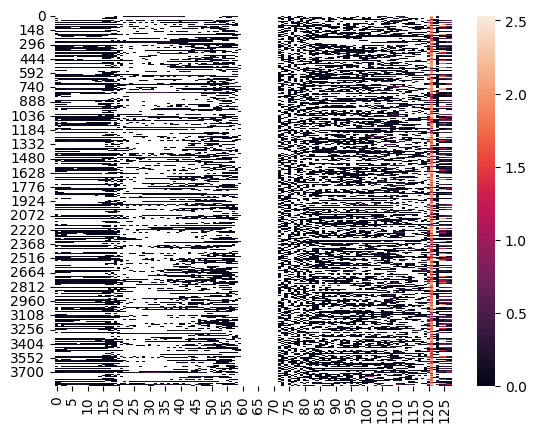

In [11]:
import pandas as pd
import seaborn as sns
tmp = pd.DataFrame(data.target_train)
sns.heatmap(tmp[tmp>0])
#print(tmp.isnull().count())

<Axes: xlabel='123', ylabel='Count'>

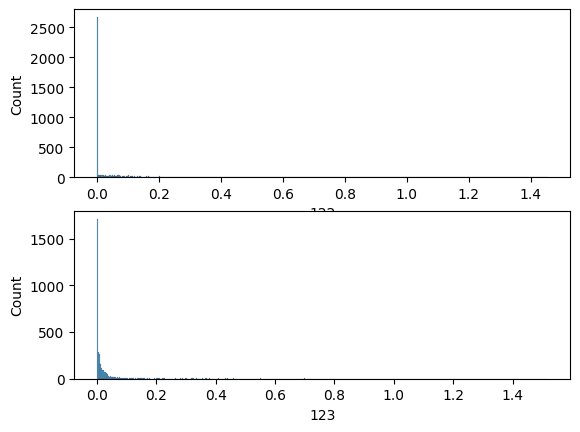

In [12]:

fig, ax = plt.subplots(2,1)
sns.histplot(tmp.loc[:,122], label = 'precipitation1', ax=ax[0])
sns.histplot(tmp.loc[:,123], label= 'precipitation2',ax=ax[1])

In [13]:
target_train_sub = tmp.loc[:,122:123]

target train column 122 : $y_{precipitation_1} = y_1$, target train column 123: $y_{precipitation_2} = y_2$

$X_{sub} \in \mathbb{R}^{3840 \times 124}$ = input_train


Model: $\mathbb{E}(y_1|X) = g(\beta^TX)$ -> g in Zero Inflated ZINB: negative binomial, log link.

Generalised linear model.

Spline regressions.

In [14]:
tmp.isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
123    0
124    0
125    0
126    0
127    0
Length: 128, dtype: int64

In [15]:
data.val_target = data.load_npy_file(val_target_path)[rd_samp_list,:]
#np.save('train_target_sub3840.npy',data.target_train, allow_pickle=True)
np.shape(data.val_target)

tmp1 = pd.DataFrame(data.val_target)

val_target_sub = tmp1.loc[:,122:123]

From here we start the ZI model

In [16]:
# Calculating mean and variance for non-zero values of both columns
non_zero_snow = target_train_sub[target_train_sub[122] > 0][122]
non_zero_rain = target_train_sub[target_train_sub[123] > 0][123]

mean_snow = non_zero_snow.mean()
variance_snow = non_zero_snow.var()

mean_rain = non_zero_rain.mean()
variance_rain = non_zero_rain.var()

mean_snow, variance_snow, mean_rain, variance_rain

(0.123456776, 0.023631379, 0.051637717, 0.015058406)

**Results :** \\
Snow Rate (Column 122): \\
Mean: 0.1235 \\
Variance: 0.0236 \\

Rain Rate (Column 123): \\
Mean: 0.0516 \\
Variance: 0.0151 \\

We can decide the ZI model among the two: \\
1. **Zero-Inflated Poisson (ZIP)**: Suitable if the non-zero data seems to follow a Poisson distribution. \\
2. **Zero-Inflated Negative Binomial (ZINB)**: Suitable if the non-zero data exhibits overdispersion (variance > mean). \\

If the variance is significantly larger than the mean, it suggests overdispersion, making ZINB a better choice. Otherwise, ZIP might be more appropriate. \\

Since for both columns, the variance is not significantly larger than the mean, the **Zero-Inflated Poisson (ZIP) model** might be a suitable choice.


In [17]:
input_train_data = data.input_train

In [22]:
import statsmodels.api as sm

# Define the independent variable (constant) and dependent variable (snow rate)
X_train_snow = sm.add_constant(input_train_data)
y_train_snow = target_train_sub[122]

# Train the Zero-Inflated Poisson model
zip_model_snow = sm.ZeroInflatedPoisson(y_train_snow, X_train_snow).fit()

# Display the model summary
zip_model_snow.summary()


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:1360: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.116659
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                     122   No. Observations:                 3840
Model:             ZeroInflatedPoisson   Df Residuals:                     3715
Method:                            MLE   Df Model:                          124
Date:                 Wed, 01 Nov 2023   Pseudo R-squ.:                  0.2618
Time:                         01:54:09   Log-Likelihood:                -447.97
converged:                       False   LL-Null:                       -606.84
Covariance Type:             nonrobust   LLR p-value:                 5.885e-19
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const   -15.3361     60.074     -0.255      0.799    -133.079     102.407
const            -4.1490      4.697     -0.883      0.377     -13.355       5.057
x1                0.0399     32.282      0.001      0.999     -63.232      63.311
x2                0.1630      8.173      0.020      0.984     -15.856      16.182
x3               -0.0642     11.645     -0.006      0.996     -22.888      22.760
x4               -0.1982     18.643     -0.011      0.992     -36.738      36.341
x5               -0.2672     25.749     -0.010      0.992     -50.733      50.199
x6               -0.5451     19.780     -0.028      0.978     -39.314      38.224
x7               -0.6711     27.598     -0.024      0.981     -54.762      53.419
x8               -0.7112     40.681     -0.017      0.986     -80.444      79.021
x9               -0.6979     56.847     -0.012      0.990    -112.115     110.719
x10              -0.7594     74.997     -0.010      0.992    -147.751     146.232
x11              -0.7173     85.950     -0.008      0.993    -169.176     167.742
x12              -0.6132     88.764     -0.007      0.994    -174.588     173.362
x13              -0.3948     88.153     -0.004      0.996    -173.172     172.383
x14              -0.1116     82.327     -0.001      0.999    -161.470     161.247
x15               0.2372     60.582      0.004      0.997    -118.502     118.976
x16               0.6044     39.765      0.015      0.988     -77.333      78.541
x17               0.8141     31.512      0.026      0.979     -60.947      62.576
x18               1.0318     16.866      0.061      0.951     -32.025      34.088
x19               1.0737     14.239      0.075      0.940     -26.834      28.982
x20               1.1276     15.748      0.072      0.943     -29.738      31.993
x21               0.8890     17.490      0.051      0.959     -33.391      35.169
x22               0.7058     22.924      0.031      0.975     -44.224      45.635
x23               0.4116     34.346      0.012      0.990     -66.906      67.729
x24               0.1800     52.123      0.003      0.997    -101.978     102.339
x25              -0.0281     74.129     -0.000      1.000    -145.317     145.261
x26              -0.1480    102.270     -0.001      0.999    -200.594     200.298
x27              -0.2153    132.181     -0.002      0.999    -259.285     258.854
x28              -0.2325    143.379     -0.002      0.999    -281.250     280.785
x29              -0.2245    170.673     -0.001      0.999    -334.737     334.288
x30              -0.1871    189.951     -0.001      0.999    -372.484     372.110
x31              -0.1322    194.453     -0.001      0.999    -381.254     380.990
x32              -0.0792    168.448     -0.000      1.000    -330.232     330.073
x33              -0.0247    136.218     -0.000      1.000    -267.008     266.958
x34               0.0225    168.827      0.000      1.000    -330.873     330.918
x35               0.0607    175.67

In [23]:
# Define the independent variable (constant) and dependent variable (rain rate)
X_train_rain = sm.add_constant(input_train_data)
y_train_rain = target_train_sub[123]

# Train the Zero-Inflated Poisson model
zip_model_rain = sm.ZeroInflatedPoisson(y_train_rain, X_train_rain).fit()

# Display the model summary
zip_model_rain.summary()

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:1360: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.111291
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                     123   No. Observations:                 3840
Model:             ZeroInflatedPoisson   Df Residuals:                     3715
Method:                            MLE   Df Model:                          124
Date:                 Wed, 01 Nov 2023   Pseudo R-squ.:                  0.2580
Time:                         01:54:15   Log-Likelihood:                -427.36
converged:                       False   LL-Null:                       -575.92
Covariance Type:             nonrobust   LLR p-value:                 3.071e-16
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const   -19.3203    294.215     -0.066      0.948    -595.972     557.331
const            -4.2002      3.932     -1.068      0.285     -11.907       3.507
x1                0.0652     37.058      0.002      0.999     -72.566      72.697
x2                0.3562      7.307      0.049      0.961     -13.966      14.678
x3               -0.0538      7.265     -0.007      0.994     -14.293      14.186
x4               -0.2585     10.902     -0.024      0.981     -21.625      21.108
x5               -0.4450     16.244     -0.027      0.978     -32.283      31.393
x6               -0.7752     14.312     -0.054      0.957     -28.827      27.276
x7               -0.8452     17.795     -0.047      0.962     -35.723      34.032
x8               -0.8651     24.559     -0.035      0.972     -49.000      47.270
x9               -0.9208     32.783     -0.028      0.978     -65.174      63.332
x10              -1.1956     34.194     -0.035      0.972     -68.215      65.824
x11              -1.2333     29.132     -0.042      0.966     -58.331      55.864
x12              -0.9349     24.242     -0.039      0.969     -48.449      46.579
x13              -0.6574     27.270     -0.024      0.981     -54.106      52.791
x14              -0.4548     26.778     -0.017      0.986     -52.938      52.029
x15              -0.0513     18.267     -0.003      0.998     -35.854      35.752
x16               0.4936      9.176      0.054      0.957     -17.491      18.478
x17               1.2537      6.684      0.188      0.851     -11.847      14.354
x18               1.9792      5.459      0.363      0.717      -8.720      12.678
x19               1.6803      5.179      0.324      0.746      -8.471      11.832
x20               1.4460      6.677      0.217      0.829     -11.640      14.532
x21               1.3813     10.900      0.127      0.899     -19.982      22.745
x22               1.1022     17.282      0.064      0.949     -32.770      34.974
x23               0.7730     27.494      0.028      0.978     -53.113      54.659
x24               0.4272     40.588      0.011      0.992     -79.123      79.978
x25               0.0790     54.403      0.001      0.999    -106.548     106.706
x26              -0.1851     69.651     -0.003      0.998    -136.699     136.329
x27              -0.3636     90.541     -0.004      0.997    -177.820     177.093
x28              -0.4705    103.764     -0.005      0.996    -203.844     202.903
x29              -0.5187    119.796     -0.004      0.997    -235.315     234.278
x30              -0.4941    129.464     -0.004      0.997    -254.239     253.250
x31              -0.4173    135.864     -0.003      0.998    -266.706     265.872
x32              -0.3516    116.161     -0.003      0.998    -228.023     227.320
x33              -0.2752    110.800     -0.002      0.998    -217.440     216.889
x34              -0.2091    118.545     -0.002      0.999    -232.553     232.135
x35              -0.1521    117.81

In [24]:
# Make predictions using the trained ZIP models
X_test_snow = sm.add_constant(input_train_data)
X_test_rain = sm.add_constant(input_train_data)

predicted_snow = zip_model_snow.predict(X_test_snow)
predicted_rain = zip_model_rain.predict(X_test_rain)

# Calculate the Mean Absolute Error (MAE) for the predictions
mae_snow = (abs(predicted_snow - val_target_sub[122])).mean()
mae_rain = (abs(predicted_rain - val_target_sub[123])).mean()

mae_snow, mae_rain
print("MAE for Snow Rate: ", mae_snow)
print("MAE for Rain Rate: ", mae_rain)


MAE for Snow Rate:  0.03580687862011734
MAE for Rain Rate:  0.05440257581897902


**Mean Absolute Errors (MAE)** \\
$$
MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| \\
$$
MAE represent the average absolute difference between the predicted and actual values in the testing dataset. Lower MAE values indicate better model performance.

**Result :** \\
According to the fact that MAE for Snow Rate is smaller, it can be concluded that the model for Snow is more accurate than Rain.